## **Import statements + set up device**

In [58]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from random import randrange
import pandas as pd

In [60]:
# use a gpu if it is available
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, the following should print a CUDA device
print(f"Currently runninng on: {device}")

Currently runninng on: cuda:0


## **Hyperparameters**

In [61]:
# Hyper-parameters 
num_epochs = 50
batch_size = 40
learning_rate = 0.001
validation_data_size = 0.2

## **Prepare data**

In [62]:
# load training data
training_images = "/content/drive/My Drive/Colab Notebooks/images_l.pkl"
training_labels = "/content/drive/My Drive/Colab Notebooks/labels_l.pkl"

with open(training_images, 'rb') as f: 
    X_train = pickle.load(f)

with open(training_labels, 'rb') as f: 
    y_train = pickle.load(f)

# Determine size of split for training and validation // Example = 24000 and 7000
training_data_size = 1.0-validation_data_size
training_data_size = (int) ((1.0-validation_data_size)*X_train.shape[0])
validation_data_size = (int) (X_train.shape[0] - training_data_size)
print(f'Size of training data    : {training_data_size}')
print(f'Size of validation data  : {validation_data_size}')

# need to ensure that 1 channel is specified - need this later when applying conv layer
X_train = X_train.reshape(30000,1,56,56)
# covert data to float tensors 
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

print(f"Size of features :    {X_train.shape}")
print(f"Size of labels   :    {y_train.shape}")

# create a dataset out of all the data
all_data = torch.utils.data.TensorDataset(X_train,y_train)

# split randomly between training and validation data
training_data , validation_data = torch.utils.data.random_split(all_data,[training_data_size,validation_data_size])

# create train and validation loaders with specified batch size (this is a hyperparameter we can tweak)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

Size of training data    : 24000
Size of validation data  : 6000
Size of features :    torch.Size([30000, 1, 56, 56])
Size of labels   :    torch.Size([30000, 36])


## **CNN Architecture and Training**

In [63]:
# method to train model using a dataloader
def train_model(dataloader):
  print("Training model:")
  train_losses = []
  n_total_steps = len(dataloader)
  for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
      
      images,labels = data
      images = images.to(device)
      labels = labels.to(device)
                        
      # Forward pass:
      outputs = model(images)
      loss = criterion(outputs, labels)
      train_losses.append(loss)

      # Backward pass - compute gradients:
      optimizer.zero_grad() # empty gradients
      loss.backward() 
      optimizer.step()
      # print usefull information while training:
      if (i+1) % 500 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

In [64]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(p=0.2)
    self.batchnorm16 = nn.BatchNorm2d(16)
    self.batchnorm32 = nn.BatchNorm2d(32)
    self.conv1 = nn.Conv2d(1, 16, 3)
    self.conv2 = nn.Conv2d(16, 16, 3, padding='same')
    self.conv3 = nn.Conv2d(16, 16, 3, padding='same')
    self.conv4 = nn.Conv2d(16, 32, 3, padding='same')
    self.conv5 = nn.Conv2d(32, 32, 3, padding='same')
    self.conv6 = nn.Conv2d(32, 32, 3, padding='same')
    self.conv7 = nn.Conv2d(32, 32, 3, padding='same')
    self.conv8 = nn.Conv2d(32, 32, 3, padding='same')
    self.fc1 = nn.Linear(32 * 3 * 3, 144)
    self.fc2 = nn.Linear(144, 108)
    self.fc3 = nn.Linear(108, 36)


  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm16(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = self.batchnorm16(x)
    x = F.relu(self.conv3(x))
    x = self.batchnorm16(x)
    x = self.pool(F.relu(self.conv4(x)))
    x = self.dropout(x)
    x = self.batchnorm32(x)
    x = F.relu(self.conv5(x))
    x = self.batchnorm32(x)
    x = self.pool(F.relu(self.conv6(x)))
    x = self.batchnorm32(x)
    x = F.relu(self.conv7(x))
    x = self.pool(F.relu(self.conv8(x)))
    x = self.batchnorm32(x)
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


# initialize our model
model = ConvNet().to(device)
# define the cross entropy loss function - note that this automatically peforms softmax
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
# call model on training loader with labeled data:
train_model(train_loader)

Training model:
Epoch [1/50], Step [500/600], Loss: 6.0296
Epoch [2/50], Step [500/600], Loss: 5.0209
Epoch [3/50], Step [500/600], Loss: 3.7726
Epoch [4/50], Step [500/600], Loss: 2.9802
Epoch [5/50], Step [500/600], Loss: 3.6367
Epoch [6/50], Step [500/600], Loss: 2.3227
Epoch [7/50], Step [500/600], Loss: 2.1504
Epoch [8/50], Step [500/600], Loss: 2.3918
Epoch [9/50], Step [500/600], Loss: 1.9537
Epoch [10/50], Step [500/600], Loss: 1.8686
Epoch [11/50], Step [500/600], Loss: 2.0152
Epoch [12/50], Step [500/600], Loss: 2.0557
Epoch [13/50], Step [500/600], Loss: 1.9608
Epoch [14/50], Step [500/600], Loss: 1.8598
Epoch [15/50], Step [500/600], Loss: 2.0875
Epoch [16/50], Step [500/600], Loss: 1.8591
Epoch [17/50], Step [500/600], Loss: 1.9250
Epoch [18/50], Step [500/600], Loss: 1.8197
Epoch [19/50], Step [500/600], Loss: 1.6313
Epoch [20/50], Step [500/600], Loss: 2.0577
Epoch [21/50], Step [500/600], Loss: 2.0909
Epoch [22/50], Step [500/600], Loss: 1.6576
Epoch [23/50], Step [500/

## **Data Augmentation** 

In [66]:
# create a transform to randomly rotate data to +- 10
rotate_transform = transforms.Compose([transforms.RandomRotation(degrees=10)])
X_train_rotated = rotate_transform(X_train)
# create new dataloader from rotated images and call model on rotated data to retrain
rotated_data = torch.utils.data.TensorDataset(X_train_rotated,y_train)
rotated_loader = torch.utils.data.DataLoader(rotated_data, batch_size=batch_size, shuffle=True)
train_model(rotated_loader)

Training model:
Epoch [1/50], Step [500/750], Loss: 2.3013
Epoch [2/50], Step [500/750], Loss: 2.1012
Epoch [3/50], Step [500/750], Loss: 1.7691
Epoch [4/50], Step [500/750], Loss: 1.7099
Epoch [5/50], Step [500/750], Loss: 1.9104
Epoch [6/50], Step [500/750], Loss: 1.7806
Epoch [7/50], Step [500/750], Loss: 1.6986
Epoch [8/50], Step [500/750], Loss: 1.8917
Epoch [9/50], Step [500/750], Loss: 1.9458
Epoch [10/50], Step [500/750], Loss: 1.8755
Epoch [11/50], Step [500/750], Loss: 2.0806
Epoch [12/50], Step [500/750], Loss: 1.6071
Epoch [13/50], Step [500/750], Loss: 1.8689
Epoch [14/50], Step [500/750], Loss: 1.5025
Epoch [15/50], Step [500/750], Loss: 1.7666
Epoch [16/50], Step [500/750], Loss: 1.6610
Epoch [17/50], Step [500/750], Loss: 1.5706
Epoch [18/50], Step [500/750], Loss: 1.5704
Epoch [19/50], Step [500/750], Loss: 1.6526
Epoch [20/50], Step [500/750], Loss: 1.7721
Epoch [21/50], Step [500/750], Loss: 1.5551
Epoch [22/50], Step [500/750], Loss: 1.9760
Epoch [23/50], Step [500/

## **Model Validation**

In [78]:
def validate(data_loader):
    correct = 0
    correctNums = 0
    correctLetters = 0
    total = 0

  # do not need to keep track of gradients for validation 
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            images = images.reshape(batch_size, 1, 56, 56)
          # calculate outputs by running images through the network
            outputs = model(images.float())
          # the class with the highest energy is what we choose as prediction
          #_, predicted = torch.max(outputs.data, 1)
            numbers = outputs.data[:, :10]
            _, predictedNums = torch.max(numbers, 1)
            _, actualNums = torch.max(labels[:, :10], 1)

            letters = outputs.data[:, 10:]
            
            _, predictedLetters = torch.max(letters, 1)
            _, actualLetters = torch.max(labels[:, 10:], 1)

            correctNums += (predictedNums == actualNums).sum().item()

            correctLetters += (predictedLetters == actualLetters).sum().item()

            total += predictedNums.shape[0]
            correct += ((predictedNums == actualNums) & (predictedLetters == actualLetters)).sum().item()

        ovr_acc = correct / total
        num_acc = correctNums / total
        let_acc = correctLetters / total

        print(f'=====> Total Accuracy: {ovr_acc:.4f}\t'
              f'Number Accuracy: {num_acc:.4f}\t'
              f'Letter Accuracy: {let_acc:.2f}')

In [79]:
print("Training Scores:")
validate(train_loader)
print("Validation Scores:")
validate(val_loader)

Training Scores:
=====> Total Accuracy: 0.8937	Number Accuracy: 0.9530	Letter Accuracy: 0.91
Validation Scores:
=====> Total Accuracy: 0.8803	Number Accuracy: 0.9420	Letter Accuracy: 0.90


In [69]:
print("Training Scores:")
validate(train_loader)
print("Validation Scores:")
validate(val_loader)

Training Scores:
=====> Total Accuracy: 0.9330	Number Accuracy: 0.9728	Letter Accuracy: 0.94
Validation Scores:
=====> Total Accuracy: 0.9203	Number Accuracy: 0.9665	Letter Accuracy: 0.94


## **Call model on Test data for submission**

In [77]:
def test(data_loader):

    predictions = []

  # do not need to keep track of gradients for validation 
    with torch.no_grad():
        for data in data_loader:

            images = data
           
            images = images.to(device)

            # forward pass
            outputs = model(images)

            numbers = outputs.data[:, :10]
            _, predictedNums = torch.max(numbers, 1)

            letters = outputs.data[:, 10:]
            _, predictedLetters = torch.max(letters, 1)



            for i in range(len(outputs)): #len(outputs)

              answer = np.zeros(36,dtype=np.int8)

              answer[predictedNums[i]] = 1
              answer[predictedLetters[i]+10] = 1 

              predictions.append(answer)
              
  
    # convert predictions into a strings of 1,0s for submission
    string_predictions = []
    for current_array in predictions:
      current_array = ''.join(map(str,current_array))
      string_predictions.append(current_array)

    return string_predictions

In [80]:
# load data
test_path = "/content/drive/My Drive/Colab Notebooks/images_test.pkl"
with open(test_path, 'rb') as f: 
    test_data = pickle.load(f)
# reshape data to tensors and correct channels
test_data = test_data.reshape(15000,1,56,56)
# create dataset and dataloaders
test_data = torch.from_numpy(test_data).float().to(device)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
test_output = test(testloader)
# create dataframe to output as csv
test_df = pd.DataFrame(test_output,columns=['Category'])
test_df.index.name = '# Id'
test_df.to_csv('pls_work.csv',index=True)

## **Helper Functions**

### Visualize data points

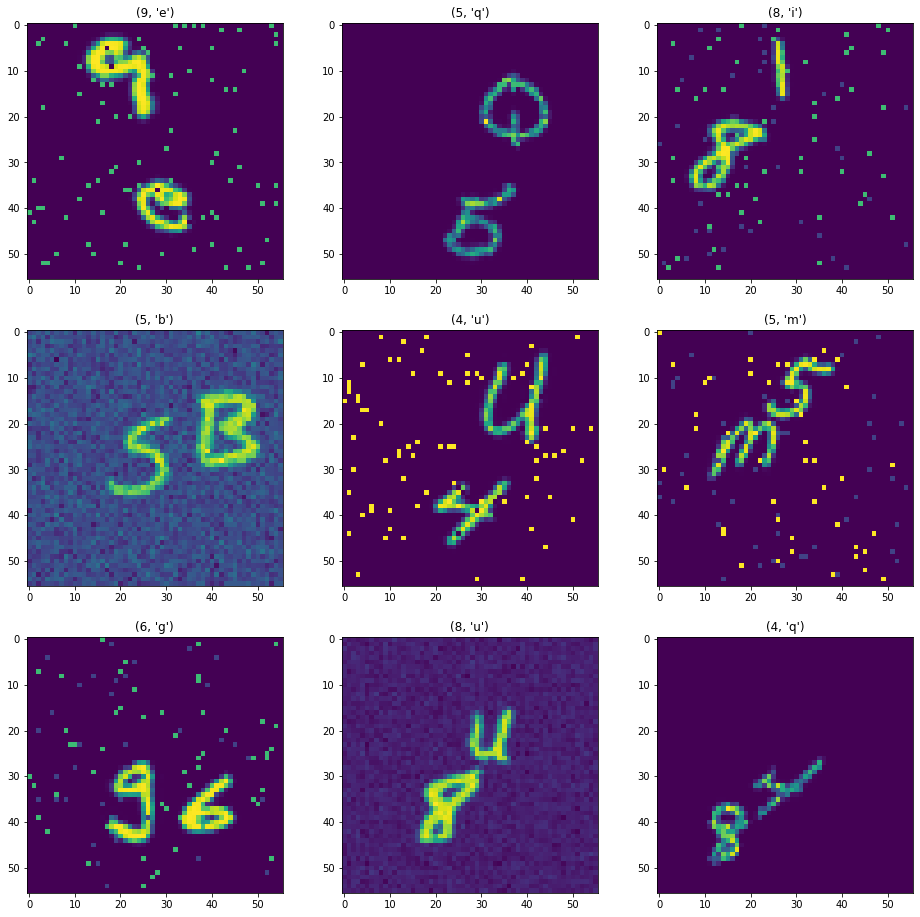

In [72]:
def peek(tensor, nm=(2,2), labels=None):

  def interpret(label):
    idxs = np.where(label == 1)[0]
    number = idxs[0]
    alphabet = chr(idxs[1] - 10 + 97)
    return (number, alphabet)
  
  tensor = tensor.squeeze(1).cpu()
  verbose = True if labels is not None else False
  if verbose:
    labels = labels.cpu()
  n, m = nm
  f, ax = plt.subplots(n, m, figsize=(16,16))
  for i in range(0, n*m):
    ax[i//m, i%m].imshow(tensor[i].numpy())
    if verbose:
      ax[i//m, i%m].set_title(f'{interpret(labels[i])}')
  plt.show()

peek(X_train, nm=(3,3), labels=y_train)

### Convert data to binary using thresholding:

In [73]:
def image_to_binary(input_images):

  binary_images = np.zeros(np.shape(input_images))
  for i in range(input_images.shape[0]):
    binary_images[i] = input_images[i][:, :] > 125 

  return binary_images

## **Playing around with unlabelled data**

### Get results for unlabelled data

In [74]:
# model.eval()
def unlabeled(data_loader):

    unlabeled_images = []
    unlabeled_labels = []

  # do not need to keep track of gradients for validation 
    with torch.no_grad():
        for data in data_loader:

            images = data
           
            images = images.to(device)

            # forward pass
            outputs = model(images)

            numbers = outputs.data[:, :10]
            _, predictedNums = torch.max(numbers, 1)

            letters = outputs.data[:, 10:]
            _, predictedLetters = torch.max(letters, 1)



            for i in range(len(outputs)):
              #print(f"Iteration # {i}")
              #check if two letters or numbers are +ve, if they are we ignore current unlabelled example
              number_of_positives_numbers = 0
              numbers_of_positive_letters = 0
              for number_pred in numbers[i]:
                number_pred = number_pred.item()
                if (number_pred>0):
                  #print(f"Number_pred:{number_pred}")
                  number_of_positives_numbers = number_of_positives_numbers + 1

              for letter_pred in letters[i]:
                letter_pred = letter_pred.item()
                if (letter_pred>0):
                  #print(f"Letter_pred:{letter_pred}")
                  numbers_of_positive_letters = numbers_of_positive_letters + 1

              
              # print("Number of positives:", number_of_positives)
              

              if (number_of_positives_numbers > 2 or numbers_of_positive_letters > 2):
                continue
              else:
                # print("We should include this:")
                # print("predicted nums:",predictedNums[i],numbers[i])
                # print("predicted letters:",predictedLetters[i], letters[i])

                label = np.zeros(36,dtype=np.float32)  
                label[predictedNums[i]] = 1
                label[predictedLetters[i]+10] = 1  
                unlabeled_labels.append(label)
                unlabeled_images.append(images[i])


    return unlabeled_images, unlabeled_labels

In [75]:
unlabeled_path = "/content/drive/My Drive/Colab Notebooks/images_ul.pkl"
with open(unlabeled_path, 'rb') as f: 
    unlabeled_data = pickle.load(f)

unlabeled_data = unlabeled_data.reshape(30000,1,56,56)
unlabeled_data = torch.from_numpy(unlabeled_data).float().to(device)
unlabeled_data = torch.utils.data.DataLoader(unlabeled_data, batch_size=batch_size)
unlabeled_images, unlabeled_labels = unlabeled(unlabeled_data)

# convert list of images (unlabeled data) to single tensor
unlabeled_images_tensor = torch.Tensor(len(unlabeled_images), 56, 56).to(device)
torch.cat(unlabeled_images, out=unlabeled_images_tensor)
unlabeled_images = unlabeled_images_tensor.view(len(unlabeled_images),1,56,56)
# convert new labels to tensor
unlabeled_labels = np.stack(unlabeled_labels, axis=0)
unlabeled_labels = torch.from_numpy(unlabeled_labels)
print(unlabeled_images.shape, unlabeled_labels.shape)

# create dataset and dataloaders for newly labeled data
newly_labeled = torch.utils.data.TensorDataset(unlabeled_images,unlabeled_labels)
new_label_dataloader = torch.utils.data.DataLoader(newly_labeled, batch_size=batch_size, shuffle=True) # look into numworkers

# train using newly labeled dataset
train_model(new_label_dataloader)

torch.Size([24087, 1, 56, 56]) torch.Size([24087, 36])
Training model:
Epoch [1/50], Step [500/603], Loss: 2.0034
Epoch [2/50], Step [500/603], Loss: 2.1399
Epoch [3/50], Step [500/603], Loss: 1.9954
Epoch [4/50], Step [500/603], Loss: 2.1064
Epoch [5/50], Step [500/603], Loss: 1.6078
Epoch [6/50], Step [500/603], Loss: 1.7992
Epoch [7/50], Step [500/603], Loss: 1.5733
Epoch [8/50], Step [500/603], Loss: 1.9401
Epoch [9/50], Step [500/603], Loss: 1.5351
Epoch [10/50], Step [500/603], Loss: 1.9198
Epoch [11/50], Step [500/603], Loss: 1.5375
Epoch [12/50], Step [500/603], Loss: 1.6508
Epoch [13/50], Step [500/603], Loss: 1.9646
Epoch [14/50], Step [500/603], Loss: 1.5398
Epoch [15/50], Step [500/603], Loss: 1.6142
Epoch [16/50], Step [500/603], Loss: 1.5466
Epoch [17/50], Step [500/603], Loss: 1.5653
Epoch [18/50], Step [500/603], Loss: 1.5802
Epoch [19/50], Step [500/603], Loss: 1.5048
Epoch [20/50], Step [500/603], Loss: 1.4972
Epoch [21/50], Step [500/603], Loss: 1.5878
Epoch [22/50],

In [76]:
print("After incorporating unlabelled data:")
print("Training Scores:")
validate(train_loader)
print("Validation Scores:")
validate(val_loader)

After incorporating unlabelled data:
Training Scores:
=====> Total Accuracy: 0.8957	Number Accuracy: 0.9547	Letter Accuracy: 0.91
Validation Scores:
=====> Total Accuracy: 0.8782	Number Accuracy: 0.9428	Letter Accuracy: 0.90
